In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d

Create grids for next period's capital holdings

In [77]:
def create_grids(n, theta):

    zero_grid=np.linspace(0, 1, n).reshape(-1,1)

    k_grid=np.zeros(shape=(n,1))

    k_low  = 1e-2

    k_high  = 100
    
    #for i in range(len(new_grid)):
        #k_grid[i] =  low_bound + ( up_bound - low_bound ) * (new_grid[i] ** 1)

    for i in range(len(zero_grid)):
        k_grid[i] =  (k_low) + ( (k_high) - (k_low) ) * (zero_grid[i] ** theta)

    return k_grid 

define various utility functions

In [3]:
def u(c, gamma):
    if gamma == 1:
        return np.log(c)
    else:
        return ((c ** (1 - gamma))/( 1 - gamma))

In [4]:
def u_ces(c,gamma, beta):
    return (1 - beta) * (c) ** (1-gamma)

define the production function

In [5]:
def f(A, alpha, delta, k):
    return A * (k ** alpha) + (1 - delta) * k

Now, create a function to linearly interpolate each column of the Value matrix, so that we can calculate the derivate at each point on the capital grid.

In [6]:
def interpolate_column(grid, column):
    interpolator = interp1d(np.squeeze(grid), column, kind = 'linear', fill_value = 'extrapolate')
    return interpolator

Let's now begin with the endogenous grid method

In [328]:
def egm(n_k, n_z, epsilon, theta, rho, A, alpha, delta, sigma, mu, toler, beta, gamma, max_iter): 
    
    # First, discretise an AR1 process using Rouwenhorst's method
    mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    z, Pi = mc.state_values, mc.P

    # Create capital, shock and resource grids
    z_grid = z
    # k_grid = create_grids(n_k, theta)
    k_grid = create_grids(n_k, theta)
    Y_grid = f(np.exp(z_grid) * A, alpha, delta, k_grid) 

    #Create a matrix to store the derivatives of the interpolated value functions on the capital grid
    derivatives = np.zeros((n_k,n_z))
    V_tilde = np.zeros((n_k,n_z))

    # Initialise value and policy functions
    j_vals = np.arange(1,16)
    V_star = (0.01 * (k_grid)) * (j_vals ** (1/gamma))
    V_star_new = np.zeros((n_k, n_z))  
    interpolated_V = np.zeros((n_k,n_z))

    it = 0

    for it in range(max_iter):

        # Create list of interpolated columns
        interpolators = [interpolate_column(k_grid, V_star[:,j]) for j in range(n_z)]

        # Update the derivatives
        for j, interpolator in enumerate(interpolators): # Here I changed how the loop is defined 
            for i in range(n_k):
                #for j in range(len(n_z)):
                    #derivatives[i,j]=((interpolators[j](k_grid[i])-interpolators[j](k_grid[i]-epsilon))/(epsilon))
                    derivatives[i,j]=((interpolator(k_grid[i])-interpolator(k_grid[i]-epsilon))/(epsilon))
        for i in range(n_z): #15 loop
            V_tilde[:,i] =  beta * np.dot(Pi[i,:], derivatives.T)
        # Now that we have the derivatives, we can use the first-order conditions to find consumption
        #c_star = (derivatives)**(-1/gamma)
        #c_star = (beta * derivatives)**(-1/gamma)
        #print(V_tilde)
        c_star = (V_tilde)**(-1/gamma)
        # Calculate the implied total resources
        Y_star = c_star + k_grid
        # Update the Value function
        V = u(c_star, gamma) + V_star # Here I added gamma as an input for the function. I don't remember if I changed how u() was defined or you forgot to include this
        # New interpolation 
        V_interpolators = [interpolate_column(Y_star[:,j], V[:,j]) for j in range(n_z)] # Changed V_star by V

        # Evaluate 
        for j, interpolator in enumerate(V_interpolators): # Here I changed how the loop is defined
            for i in range(n_k):
                interpolated_V[i,j] = V_interpolators[j](Y_grid[i, j])
        # Now, calculate the updated expected value
        #for j in range(n_z):
            #V_star_new[:, j] = beta * np.dot(interpolated_V[:, j], Pi[j,:])       
        V_star_new = beta * np.dot(interpolated_V, Pi.T) # I am not sure that this is the correct way to define this. 
        # Check error

        error = np.max(np.abs(V_star_new - V_star)/1+np.abs(V_star))

        if it % 25 == 0:
            print(f'Iteration {it} completed with error = {error}')

        if error < toler:
            break

        V_star = np.copy(V_star_new)        
        it+=1

    return V_star

In [65]:
def egm_edited(n_k, n_z, epsilon, theta, rho, A, alpha, delta, sigma, mu, toler, beta, gamma, max_iter): 

    # First, discretise an AR1 process using Rouwenhorst's method
    mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    z, Pi = mc.state_values, mc.P

    # Create capital, shock and resource grids
    z_grid = z

    k_grid = create_grids(n_k, theta)

    Y_grid = f(np.exp(z_grid) * A, alpha, delta, k_grid)
    #print(Y_grid[:,0])

    #Create a matrix to store the derivatives of the interpolated value functions on the capital grid
    derivatives = np.zeros((n_k,n_z))

    # Initialise value and policy functions
    V_star = np.zeros((n_k, n_z))  
    for i in range(n_k):
        for j in range(n_z):
            V_star[i,j] = (u(np.squeeze(k_grid[i]), gamma))

    #plt.plot(k_grid, V_star)
    #plt.show()
    #print(V_star[:,0])

    V_star_new = np.zeros((n_k, n_z))  

    interpolated_V = np.zeros((n_k,n_z))

    it = 0

    for it in range(max_iter):

        # Create list of interpolated columns
        interpolators = [interpolate_column(np.squeeze(k_grid), V_star[:,j]) for j in range(n_z)]

        # Update the derivatives
        for j, interpolator in enumerate(interpolators): # Here I changed how the loop is defined 
            for i in range(n_k):
                    derivatives[i,j]=((interpolator(k_grid[i])-interpolator(k_grid[i]-epsilon))/(epsilon))
        #print(derivatives[:,0])

        #Now that we have the derivatives, we can use the first-order conditions to find consumption
        c_star = (derivatives)**(-1/gamma)
        #print(c_star[:,0])

        # Calculate the implied total resources
        Y_star = c_star + k_grid
        #print(Y_star[:,0])

        # Update the Value function
        V = u(c_star, gamma) + V_star
        #print(V[:,1])

        #New interpolation 
        V_interpolators = [interpolate_column(Y_star[:,j], V[:,j]) for j in range(n_z)]

        # Evaluate 
        for j, interpolator in enumerate(V_interpolators): 
            for i in range(n_k):
                interpolated_V[i,j] = interpolator(Y_grid[i, j])
        #print(interpolated_V[:,0])

        # Now, calculate the updated expected value  
        for i in range(n_k):
            for j in range(n_z):   
                V_star_new[i,j] = beta * np.dot(interpolated_V[i,:], Pi[j,:]) 
        #print(V_star_new[:,0])

        # Check error
        error = np.max((np.abs(V_star_new - V_star))/(1+np.abs(V_star)))

        if it % 25 == 0:
            print(f'Iteration {it} completed with error = {error}')

        if error < toler:
            break

        V_star = np.copy(V_star_new)

        #plt.plot(k_grid, V_star)
        #plt.show()

        it+=1

    #X = np.zeros(shape=(n_k, n_z))
    #for i in range(n_k):
        #for j in range(n_z):

    return V_star

C:\Users\bayle\AppData\Local\Temp\ipykernel_17048\4278714200.py:4: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)


Iteration 0 completed with error = 0.9754185259053575
Iteration 25 completed with error = 0.012322759926048855
Iteration 50 completed with error = 0.003681580370980187
Iteration 75 completed with error = 0.001301652594820627
Iteration 100 completed with error = 0.00047037620817820097
Iteration 125 completed with error = 0.00017063891437437562
Iteration 150 completed with error = 6.186335507006082e-05
Iteration 175 completed with error = 2.2381841595171358e-05
Iteration 200 completed with error = 8.096001573620384e-06
Iteration 225 completed with error = 2.9996577652565945e-06
Iteration 250 completed with error = 1.3030336856896394e-06


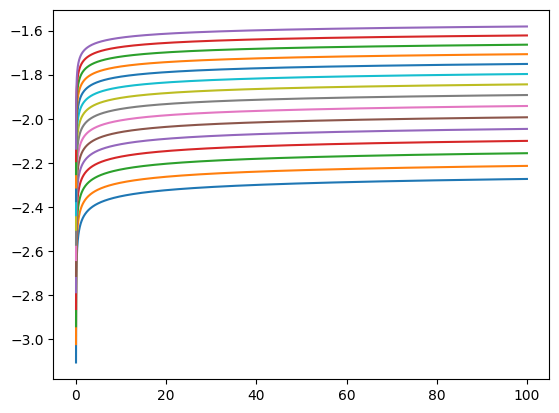

In [78]:
V = egm_edited(n_k=501, n_z=15, epsilon=1e-4, theta=2, rho=0.98, A=10, alpha=1/3, delta=1, sigma=0.01, mu=0, toler=1e-6, beta=0.96, gamma=2, max_iter=10000000)
k_grid = create_grids(501, 2)
plt.plot(k_grid, V)
plt.show()